# 1. Data preprocessing

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [76]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset_demo', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

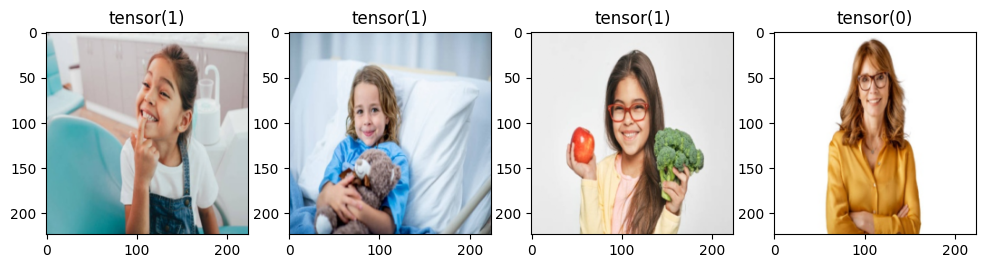

In [77]:
import numpy as np
from matplotlib import pyplot as plt
batch = next(iter(train_loader))
# clip the pixel values to be between 0 and 1
batch[0] = torch.clamp(batch[0], 0, 1)
# print 4 images
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.permute(1, 2, 0))
    ax[idx].title.set_text(batch[1][idx])

# 2. Build model

In [47]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True)
        )
class InvertedResidual(nn.Module):
    def __init__(self, in_channel, out_channel, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_channel = in_channel * expand_ratio
        self.use_shortcut = stride == 1 and in_channel == out_channel

        layers = []                          # 定义层列表
        if expand_ratio != 1:
            # 1x1 pointwise conv
            layers.append(ConvBNReLU(in_channel, hidden_channel, kernel_size=1))
        layers.extend([
            # 3x3 depthwise conv
            ConvBNReLU(hidden_channel, hidden_channel, stride=stride, groups=hidden_channel),
            # 1x1 pointwise conv(linear)
            nn.Conv2d(hidden_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)


In [48]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=2, alpha=0.75, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = _make_divisible(32 * alpha, round_nearest)          # 将卷积核个数调整到最接近8的整数倍数
        last_channel = _make_divisible(1280 * alpha, round_nearest)

        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        features = []
        # conv1 layer
        features.append(ConvBNReLU(3, input_channel, stride=2))
        # building inverted residual residual blockes
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * alpha, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, last_channel, 1))
        # combine feature layers
        self.features = nn.Sequential(*features)

        # building classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)         # 初始化均值为0
                nn.init.zeros_(m.bias)          # 初始化方差为1
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
def _make_divisible(ch, divisor=8, min_ch=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MobileNetV2(num_classes=2)
model = model.to(device)

# 3. Train

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [51]:
losses = []  # Store the loss for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    

KeyboardInterrupt: 

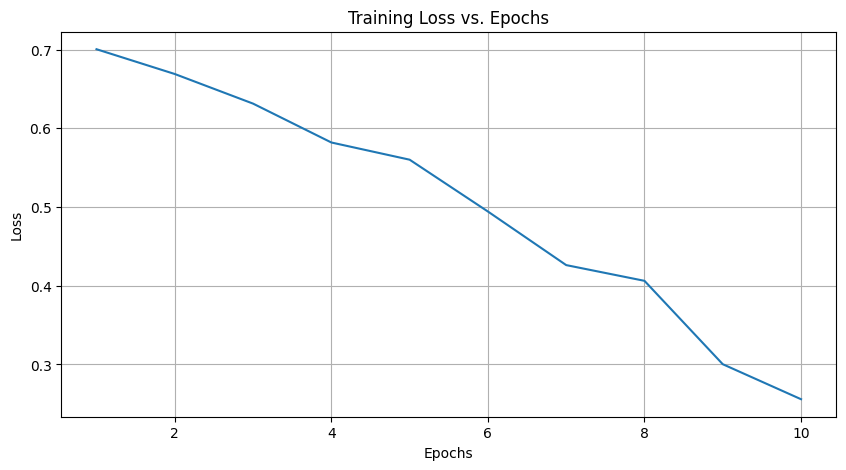

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4. Evaluation

In [ ]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
correct = 0
total = 0

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 58.33%


In [ ]:
# model complexity (number of parameters)
def profile_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
params = profile_params(model)
print(f"Parameters: {params}")

Parameters: (1279906, 1279906)


In [ ]:
# computation complexity (number of FLOPs)
def profile_flops(model, input):
    class FLOPCounter(nn.Module):
        def __init__(self, model):
            super(FLOPCounter, self).__init__()
            self.model = model
            self.total_flops = 0
            self.hooker()

        def hooker(self):
            def hook(module, input, output):
                flops = 1
                for s in list(output.size())[1:]:
                    flops *= s
                for s in list(input[0].size())[1:]:
                    flops *= s
                self.total_flops += flops

            for module in self.model.modules():
                if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                    module.register_forward_hook(hook)

        def forward(self, x):
            self.total_flops = 0
            self.model(x)
            return self.total_flops

    flops_counter = FLOPCounter(model)
    flops = flops_counter(input)
    return flops
flops = profile_flops(model, input=torch.randn(1, 3, 224, 224))
print(f"FLOPs: {flops}")

FLOPs: 1267056797568
